<a href="https://colab.research.google.com/github/baschram/bda-718-group-1/blob/master/Fleet_Classification_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pyspark Install and Drive Mounting

In [19]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark
pip install seaborn

Import required spark packages and set spark environment to use additoinal memory and cores on colab instance

In [20]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
import re
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, regexp_replace, split
from pyspark.sql.utils import AnalysisException
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, DateType, FloatType, BooleanType
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import Pipeline
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
logreg_sampled_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/therightstuff.csv")

In [22]:
logreg_sampled_df = logreg_sampled_df.filter('is_new == 0').drop('is_new')

In [23]:
#Convert boolean columns to integer to change from booleans to 0 and 1
#create list of boolena columns
bool_cols_input = ['fleet','frame_damaged','franchise_dealer','has_accidents','isCab','is_cpo','is_oemcpo','salvage','theft_title']
#Iterate through list and cast to integer type
for i in bool_cols_input:
  logreg_sampled_df = logreg_sampled_df.withColumn(i, logreg_sampled_df[i].cast(IntegerType()))

In [24]:
logreg_sampled_df.select('fleet').filter('fleet == 1').count()/logreg_sampled_df.select('fleet').count()

0.220903363419114

Due to the large class imbalance (only 22 positive for Fleet condition) it makes sense to use Precision/Recall metric as is it concerned with correct prediction of the positive class.

In [25]:
#Classifier imports and dataset split

training_df, validation_df, testing_df = logreg_sampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [26]:
enable_grid = True

# Logistic Regression Analysis

Grid search for logistic regression on data set. Removed columns that were incomplete, not appliable to the majority of vehicles or were derivatives of other columns.  Since we would likr to look at feature importance by comparing feature weights, all features were scaled using a standard scaler.  Each training run takes approx 20 minutes and the total grid search time is approx 4.5 hours.  Interestingly, adding regularization and elastic net parameters did not improve the model performance.  The scores only marginally decreased

COPY scores output from Grid search


In [27]:
#logistical Regression with Grid Search

#Create list of feature columns for use in vector assemeble
feature_cols = ['back_legroom','city_fuel_economy','daysonmarket','engine_cylinders','engine_displacement','frame_damaged','franchise_dealer','front_legroom',
                'fuel_tank_volume','has_accidents','height','highway_fuel_economy','horsepower','is_cpo','is_oemcpo','latitude','length',
                'longitude','maximum_seating','mileage','owner_count','price','salvage','savings_amount','seller_rating','theft_title','transmission_display',
                'wheelbase','width','year','torque_ftlb','torque_rpm','torque_grade','n_body_type','n_engine_type','n_fuel_type','n_transmission','n_wheel_system',
                'n_city','n_make_name','n_franchise_make','n_sp_name','n_interior_color','n_model_name','n_listing_color']

#Second preprocessing step to create feature vector and scale so feature coeffcients can be compared for importance
lr_va = feature.VectorAssembler(inputCols=feature_cols, outputCol='features')

scaler = feature.StandardScaler(withMean=True, inputCol='features')

logreg_preprocessing_2 = Pipeline(stages=[lr_va, scaler])

if enable_grid:
  lr = LogisticRegression(labelCol='fleet',featuresCol='features')

  grid = ParamGridBuilder().\
  addGrid(lr.regParam, [0., 0.01, 0.02]).\
  addGrid(lr.elasticNetParam, [0., 0.1, 0.3]).\
  build()

  lr_pipe = Pipeline(stages = [logreg_preprocessing_2,lr])

  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lr_pipe.fit(training_df, grid[j])
    all_models.append(model)
      
  scores =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models:
    score_lr_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(m.transform(validation_df))
    scores.append(score_lr_pipe_1)
        
  print(max(scores), '\n', grid[scores.index(max(scores))])
pass

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 4
Fitting model 5
Fitting model 5
Fitting model 6
Fitting model 6
Fitting model 7
Fitting model 7
Fitting model 8
Fitting model 8
Fitting model 9
Fitting model 9
Model fitting complete -> Evaluating Scores
Model fitting complete -> Evaluating Scores
0.38342567012042483 
 {Param(parent='LogisticRegression_46a6a04fb131', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_46a6a04fb131', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1}
0.38342567012042483 
 {Param(parent='LogisticRegression_46a6a04fb131', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_46a6a04fb131', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha =

In [28]:
#Feature Inference
if enable_grid:
  abs_feature_scores = [abs(i) for i in all_models[scores.index(max(scores))].stages[-1].coefficients.toArray().tolist()]
  df_col = ['feature','weight']
  abs_coeffs_df = spark.createDataFrame(data=zip(feature_cols,abs_feature_scores),schema = df_col)

  lr_important_features = abs_coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()

  display(lr_important_features)

  feature_scores = all_models[scores.index(max(scores))].stages[-1].coefficients.toArray().tolist()
  coeffs_df = spark.createDataFrame(data=zip(feature_cols,feature_scores),schema = df_col)

  lr_features_pos = coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()
  lr_features_neg = coeffs_df.sort('weight').limit(10).toPandas()

  display(lr_features_pos)
  display(lr_features_neg)
pass

,feature,weight
0,salvage,1.113535
1,torque_grade,0.741218
2,owner_count,0.414979
3,frame_damaged,0.390089
4,is_cpo,0.382678
5,theft_title,0.271235
6,maximum_seating,0.249936
7,franchise_dealer,0.236199
8,n_wheel_system,0.169123
9,has_accidents,0.061210


,feature,weight
0,owner_count,0.414979
1,frame_damaged,0.390089
2,theft_title,0.271235
3,maximum_seating,0.249936
4,is_oemcpo,0.018124
5,back_legroom,0.012594
6,n_franchise_make,0.004544
7,n_transmission,0.002673
8,highway_fuel_economy,0.002613
9,transmission_display,0.001297


,feature,weight
0,salvage,-1.113535
1,torque_grade,-0.741218
2,is_cpo,-0.382678
3,franchise_dealer,-0.236199
4,n_wheel_system,-0.169123
5,has_accidents,-0.061210
6,n_body_type,-0.033242
7,latitude,-0.030091
8,seller_rating,-0.029441
9,n_listing_color,-0.027994


Below is the optimized model

In [30]:
#LR Optimized Model
alpha_par = 0.01
lambda_par = 0.1

lr = LogisticRegression(labelCol='fleet',featuresCol='features',regParam=lambda_par, elasticNetParam=alpha_par)

lr_pipe = Pipeline(stages = [logreg_preprocessing_2,lr])

opt_lr = lr_pipe.fit(training_df)

score_lr_pipe_1_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(opt_lr.transform(validation_df))
score_lr_pipe_1_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(opt_lr.transform(validation_df))

print(score_lr_pipe_1)
print('AUC ROC: ',score_rf_roc)
print('AUC PR: ',score_rf_pr)

0.3812550516933841


Code to look at feature importance.  The first table shows the absolute values of feature weights giving an idication the most imporant features in determining if a vehicle was in a fleet or not.  The following two show the actual values to give an indication on which features indicate positive correlation to being a fleet vehicle or neagtive correlation respectively.

In [31]:
feature_scores = opt_lr.stages[-1].coefficients.toArray().tolist()
abs_feature_scores = [abs(i) for i in opt_lr.stages[-1].coefficients.toArray().tolist()]

df_col = ['feature','weight','abs_weight']
abs_coeffs_df = pd.DataFrame({'feature': feature_cols,
                              'weight': feature_scores,
                              'abs_weight': abs_feature_scores})

lr_important_features = abs_coeffs_df.sort_values('abs_weight',ascending=False)

display(lr_important_features)

#feature_scores = opt_lr.stages[-1].coefficients.toArray().tolist()
#coeffs_df = spark.createDataFrame(data=zip(feature_cols,feature_scores),schema = df_col)

#lr_features_pos = coeffs_df.sort(fn.desc('weight')).toPandas()
#lr_features_neg = coeffs_df.sort('weight').toPandas()

#display(lr_features_pos)
#display(lr_features_neg)

,feature,weight,abs_weight
32,torque_grade,-0.709929,0.709929
22,salvage,-0.494289,0.494289
5,frame_damaged,0.337285,0.337285
13,is_cpo,-0.248896,0.248896
25,theft_title,0.210891,0.210891
20,owner_count,0.175646,0.175646
6,franchise_dealer,-0.162414,0.162414
37,n_wheel_system,-0.125713,0.125713
18,maximum_seating,0.115323,0.115323
9,has_accidents,-0.063154,0.063154


# Random Forest Analysis

Examine tranformed trainign dataset to see features with high number of categories.  Random forest models on colab see to suffer from java errors if maxbin size is set too high (maxbin size must be equal to the highest number of categroies in any feature)

In [ ]:
logreg_sampled_df.describe().show()

Attempted to build a Random forest model to see if it could perform better than the logistic regression.  There were issues try to run the random forest model with all the features used in the previous model as the maxbin size needed to set to the highest number categories in any feature.  The SP name and Interior color columns were dropped so the maxbin size could be set at 4482 instead of 24607 or 16298.

In [34]:
rf_feature_cols = ['back_legroom','city_fuel_economy','daysonmarket','engine_cylinders','engine_displacement','frame_damaged','franchise_dealer','front_legroom',
                'fuel_tank_volume','has_accidents','height','highway_fuel_economy','horsepower','is_cpo','is_oemcpo','latitude','length',
                'longitude','maximum_seating','mileage','owner_count','price','salvage','savings_amount','seller_rating','theft_title','transmission_display',
                'wheelbase','width','year','torque_ftlb','torque_rpm','torque_grade','n_body_type','n_engine_type','n_fuel_type','n_transmission','n_wheel_system',
                'n_city','n_make_name','n_franchise_make','n_model_name','n_listing_color']

if enable_grid:
  rf_va = feature.VectorAssembler(inputCols=rf_feature_cols, outputCol='features')

  rf = RandomForestClassifier(featuresCol='features', labelCol='fleet', maxBins=4482)
  
  paramGrid = ParamGridBuilder().\
  addGrid(rf.numTrees, [20,30,40]).\
  addGrid(rf.maxDepth, [5,7,9]).\
  build()

  rf_pipe = Pipeline(stages = [rf_va,rf])

  all_models = []
  for j in range(len(paramGrid)):
    print("Fitting model {}".format(j+1))
    model = rf_pipe.fit(training_df, paramGrid[j])
    all_models.append(model)
      
  scores =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models:
    score_rf_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(m.transform(validation_df))
    scores.append(score_rf_pipe_1)
        
  print(max(scores), '\n', paramGrid[scores.index(max(scores))])
  pass


Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Model fitting complete -> Evaluating Scores
0.7536376780844344 
 {Param(parent='RandomForestClassifier_235748d2e666', name='numTrees', doc='Number of trees to train (>= 1).'): 40, Param(parent='RandomForestClassifier_235748d2e666', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 9}


In [33]:
scores

[0.6032218499207642,
 0.6540203979990387,
 0.7123807267860529,
 0.5576451927372064,
 0.6430365274114613,
 0.7043033407792643,
 0.5900472647835282,
 0.656331368585091,
 0.7126878109187197]

In [35]:
#Random Forest
maxdepth = 9
numtrees = 40

#Second preprocessing step to create feature vector and scale so feature coeffcients can be compared for importance
rf_va = feature.VectorAssembler(inputCols=rf_feature_cols, outputCol='features')

rf = RandomForestClassifier(featuresCol='features', labelCol='fleet', maxBins=4482, numTrees = numtrees, maxDepth = maxdepth)

rf_pipe = Pipeline(stages = [rf_va,rf]).fit(training_df)

trans = rf_pipe.transform(validation_df)
score_rf_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(trans)
score_rf_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(trans)
print('AUC ROC: ',score_rf_roc)
print('AUC PR: ',score_rf_pr)



AUC ROC:  0.8945151162379057
AUC PR:  0.753630863472764


In [36]:
pd.DataFrame(list(zip(rf_feature_cols, rf_pipe.stages[-1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

,column,weight
29,year,0.409421
19,mileage,0.109420
20,owner_count,0.048645
39,n_make_name,0.037899
21,price,0.033223
16,length,0.024229
27,wheelbase,0.023218
15,latitude,0.021761
41,n_model_name,0.021318
31,torque_rpm,0.020103


# Regression Comparison

In [44]:
rf_preds = rf_pipe.transform(testing_df)
lr_preds = opt_lr.transform(testing_df)

preds_rf_rdd = rf_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
preds_lr_rdd = lr_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))



In [38]:
comp_score_rf_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(rf_preds)
comp_score_rf_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(rf_preds)

comp_score_lr_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(lr_preds)
comp_score_lr_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(lr_preds)


print('Random Forest AUC ROC Score:',comp_score_rf_roc,
      "\nRandom Forest AUC PR Score:",comp_score_rf_pr,
      "\n",
      "\nLinear Regression AUC ROC Score:",comp_score_lr_roc,
      "\nLinear Regression AUC PR Score:",comp_score_lr_pr)



Random Forest AUC ROC Score: 0.8975451410003403 
Random Forest AUC PR Score: 0.7613840311285704 
 
Linear Regression AUC ROC Score: 0.709115042717756 
Linear Regression AUC PR Score: 0.38537740751254734


https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

In [45]:
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

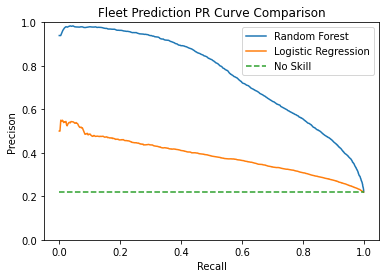

In [49]:
points_rf_rdd_pr = CurveMetrics(preds_rf_rdd).get_curve('pr')
points_lr_rdd_pr = CurveMetrics(preds_lr_rdd).get_curve('pr')

x_val_rf = [x[0] for x in points_rf_rdd_pr]
y_val_rf = [x[1] for x in points_rf_rdd_pr]
plt.plot(x_val_rf, y_val_rf, label='Random Forest')

x_val_lr = [x[0] for x in points_lr_rdd_pr]
y_val_lr = [x[1] for x in points_lr_rdd_pr]
plt.plot(x_val_lr, y_val_lr, label='Logistic Regression')

no_skill = testing_df.select('fleet').filter('fleet ==1').count()/testing_df.select('fleet').count()
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.title('Fleet Prediction PR Curve Comparison')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.ylim(0,1)
plt.show()

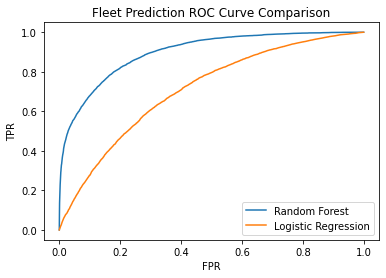

In [51]:
preds_rf_rdd = rf_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
points_rf_rdd = CurveMetrics(preds_rf_rdd).get_curve('roc')

x_val_rf = [x[0] for x in points_rf_rdd]
y_val_rf = [x[1] for x in points_rf_rdd]
plt.plot(x_val_rf, y_val_rf, label='Random Forest')

preds_lr_rdd = lr_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
points_lr_rdd = CurveMetrics(preds_lr_rdd).get_curve('roc')

x_val_lr = [x[0] for x in points_lr_rdd]
y_val_lr = [x[1] for x in points_lr_rdd]
plt.plot(x_val_lr, y_val_lr, label='Logistic Regression')

plt.title('Fleet Prediction ROC Curve Comparison')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [50]:
no_skill


0.21975582685904552